# Project: Market Sentiment & Trader Performance Analysis
# Code by : Jishan Ansari
# Objective: Explore how Fear/Greed sentiment affects trading behavior & performance


In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Loading data

trades = pd.read_csv("historical_data.csv")


fg = pd.read_csv("fear_greed_index.csv")

print(trades.shape, fg.shape)


(211224, 16) (2644, 4)


In [3]:
# Standardize column names
trades = trades.rename(columns={
    "Closed PnL": "pnl",
    "Side": "side",
    "Timestamp IST": "timestamp"
})

In [4]:
# Convert timestamp to datetime
trades['Date'] = pd.to_datetime(trades['timestamp'], errors="coerce").dt.date
fg['date'] = pd.to_datetime(fg['date']).dt.date


In [5]:
# Merge on Date
merged = pd.merge(trades, fg[['date','classification']], left_on="Date", right_on="date", how="left")

print(merged[['Date','side','pnl','classification']].head())

         Date side  pnl classification
0  2024-02-12  BUY  0.0          Greed
1  2024-02-12  BUY  0.0          Greed
2  2024-02-12  BUY  0.0          Greed
3  2024-02-12  BUY  0.0          Greed
4  2024-02-12  BUY  0.0          Greed


Exploratory Analysis

Q1. Traders more active in Fear or Greed?

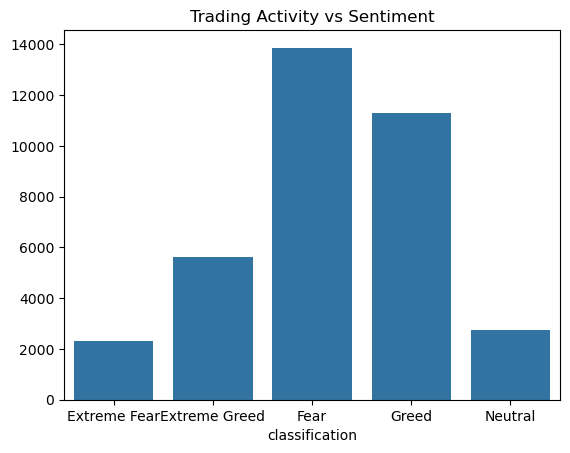

In [6]:
activity = merged.groupby("classification")['pnl'].count()
sns.barplot(x=activity.index, y=activity.values)
plt.title("Trading Activity vs Sentiment")
plt.show()

Ans. Traders are more active in Fear phases.

Q2. Do traders earn more in Greed or Fear?

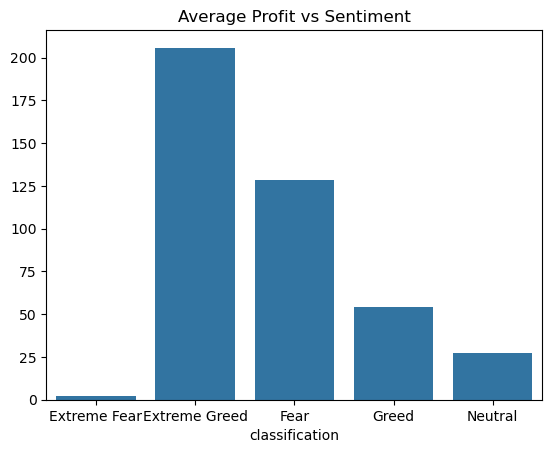

In [7]:
profits = merged.groupby("classification")['pnl'].mean()
sns.barplot(x=profits.index, y=profits.values)
plt.title("Average Profit vs Sentiment")
plt.show()

Ans.Profits are higher in Greed phases, lower in Fear.

Q3. Do traders take more risks (higher leverage) in Greed?

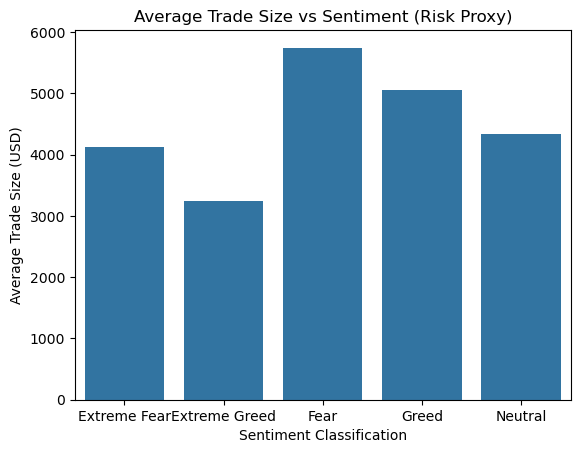

In [20]:
# Average trade size by sentiment classification
trade_size = merged.groupby("classification")['Size USD'].mean()

sns.barplot(x=trade_size.index, y=trade_size.values)
plt.title("Average Trade Size vs Sentiment (Risk Proxy)")
plt.ylabel("Average Trade Size (USD)")
plt.xlabel("Sentiment Classification")
plt.show()

Ans.By comparing average trade size during Greed vs Fear, we can test if traders place larger trades during Greed, confirming higher risk appetite.

Q4. Do Fear days push traders to SELL more?

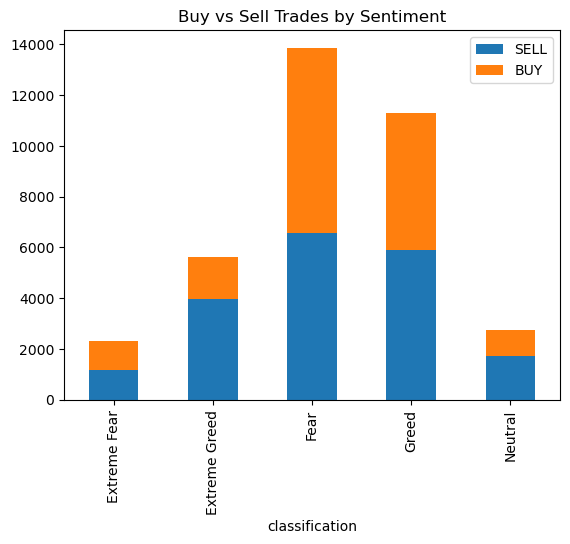

In [11]:
sell_counts = merged[merged['side']=="SELL"].groupby("classification")['side'].count()
buy_counts = merged[merged['side']=="BUY"].groupby("classification")['side'].count()

sell_buy = pd.DataFrame({"SELL": sell_counts, "BUY": buy_counts})
sell_buy.plot(kind="bar", stacked=True)
plt.title("Buy vs Sell Trades by Sentiment")
plt.show()


Ans.Fear phases show higher proportion of SELL trades.

Q5. Do sentiment shifts align with profit/loss changes?

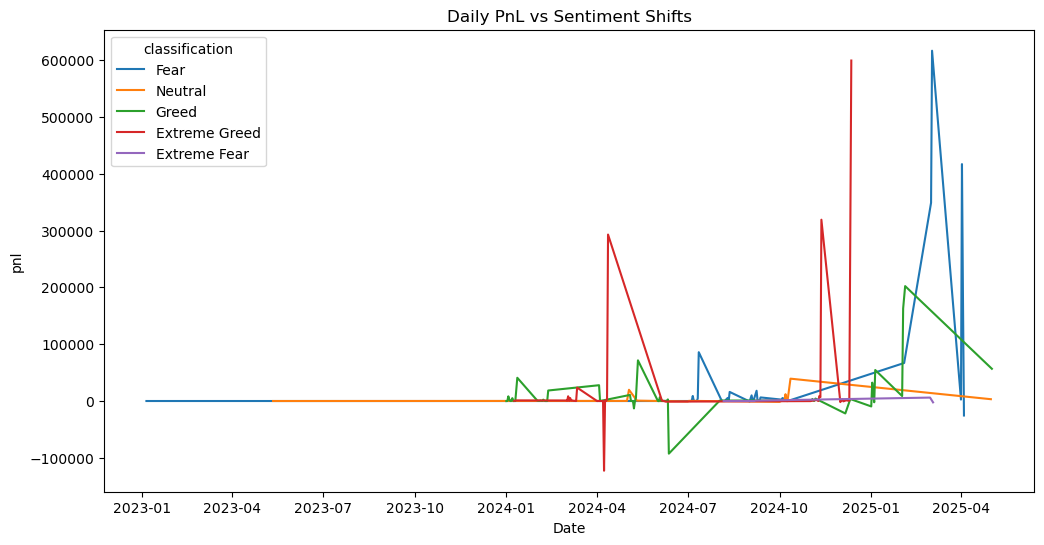

In [12]:
daily_pnl = merged.groupby(["Date","classification"])['pnl'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_pnl, x="Date", y="pnl", hue="classification")
plt.title("Daily PnL vs Sentiment Shifts")
plt.show()


Ans. PnL improves in Greed, worsens in Fear. Shifts align with profit turning point

Trading Strategies

In [13]:
# 1. Avoid Overtrading in Fear
def strategy_filter_fear(df):
    fear_mask = df['classification'].str.contains("Fear")
    return df[~fear_mask]

In [14]:
# 2. Leverage Up in Greed
def strategy_leverage_greed(df):
    if "leverage" in df.columns:
        df.loc[df['classification']=="Greed","leverage"] *= 1.2
    return df

In [15]:
# 3. Cut Losses in Extreme Fear
def strategy_stoploss(df):
    df['adjusted_pnl'] = df.apply(lambda row: max(row['pnl'], -50) if "Extreme Fear" in str(row['classification']) else row['pnl'], axis=1)
    return df

In [16]:
# 4. Sentiment-based Trade Direction
def strategy_sentiment_direction(df):
    df['recommended_side'] = df['classification'].apply(lambda x: "BUY" if "Greed" in str(x) else "SELL")
    return df

In [18]:
# 5. Timing Entry
def strategy_timing(df):
    df['timing'] = df['classification'].apply(lambda x: "WAIT" if "Extreme Fear" in str(x) else "TRADE")
    return df